In [1]:
!pip install gensim --upgrade
!pip install -U keras-tuner
!pip install pymysql
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 24.0/24.0 MB 3.9 MB/s eta 0:00:00


Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 176.1/176.1 kB 2.7 MB/s eta 0:00:00


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.13.0-cp39-cp39-win_amd64.whl (1.9 kB)


In [1]:
import IPython
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import pandas as pd
import numpy as np
import pymysql

In [3]:
stock = pd.read_csv('labeled_stock_prices.csv')
stock

,Unnamed: 0,stock_id,date,closing_price,market_price,high_price,low_price,label1,label2
0,0,80,2023-08-02,20300.0,20600.0,20700.0,20250.0,0,1
1,1,80,2023-08-01,20550.0,20350.0,20700.0,20250.0,1,1
2,2,80,2023-07-31,20300.0,20250.0,20700.0,20150.0,1,1
3,3,80,2023-07-28,20050.0,20000.0,20250.0,19920.0,1,0
4,4,80,2023-07-27,20250.0,19150.0,20250.0,19150.0,1,0
...,...,...,...,...,...,...,...,...,...
12995,12995,402340,2023-05-08,42100.0,42100.0,42400.0,41750.0,1,1
12996,12996,402340,2023-05-04,41800.0,41500.0,42300.0,41350.0,1,0
12997,12997,402340,2023-05-03,41750.0,41200.0,42050.0,41200.0,1,0
12998,12998,402340,2023-05-02,41350.0,42500.0,42500.0,40500.0,0,1


In [4]:
news = pd.read_csv('final.csv')
news

,Unnamed: 0,stock_id,text,date,stock_name,category,label,token,token_list
0,0,80,안호근 한국농업기술진흥원 원장 안호근 한국농업기술진흥원 원장은 첨단기술에 기반한 농...,2023-07-31,하이트진로,생활소비재,1,"['안호근', '한국농업기술진흥원', '원장', '안호근', '한국농업기술진흥원',...","['안호근', '한국농업기술진흥원', '원장', '안호근', '한국농업기술진흥원',..."
1,1,80,김성희 고려대 노동대학원 교수 한국 불안정한 노사관계 심각한 수준 취약계층 중심의...,2023-07-31,하이트진로,생활소비재,1,"['김성희', '노동대학원', '교수', '한국', '불안정한', '노사관계', '...","['김성희', '노동대학원', '교수', '한국', '불안정한', '노사관계', '..."
2,2,80,내수용은 공장 출고가 수출용은 평균 계약단가 기준 내수용 출고가에 관세 주세 교육세...,2023-07-31,하이트진로,생활소비재,1,"['내수용', '공장', '출고', '수출용', '평균', '계약단', '기준', ...","['내수용', '공장', '출고', '수출용', '평균', '계약단', '기준', ..."
3,3,80,대기업 브랜드 밀맥주 카스 화이트뿐 유흥시장 중심 마케팅에 밀맥주 소홀 가정시장 커...,2023-07-31,하이트진로,생활소비재,1,"['대기업', '브랜드', '밀맥주', '카스', '화이트', '유흥시장', '중심...","['대기업', '브랜드', '밀맥주', '카스', '화이트', '유흥시장', '중심..."
4,4,80,켈리 재판매 및 DB 금지 류난영 기자 하이트진로의 맥주 켈리 와 롯데칠성음료의 소...,2023-07-31,하이트진로,생활소비재,1,"['켈리', '재판매', '금지', '류난영', '기', '하이트진로', '맥주',...","['켈리', '재판매', '금지', '류난영', '하이트진로', '맥주', '켈리'..."
...,...,...,...,...,...,...,...,...,...
132331,132332,402340,LG에너지솔루션 개인 순매수 1위 3일 코스피지수가 1 가까이 하락했다 이날 코스피...,2023-05-03,SK스퀘어,정보기술,1,"['에너지솔루션', '개', '순매수', '1위', '3', '코스피지수', '1'...","['에너지솔루션', '순매수', '코스피지수', '코스피지수', '거래', '지수'..."
132332,132333,402340,투자금은 자산 매각으로 마련하라 SK그룹 투자 신중론 회장 지시 자금 조달 빨간불...,2023-05-03,SK스퀘어,정보기술,1,"['투자금', '자산', '매각', '마련', '그룹', '투', '신중론', '회...","['투자금', '자산', '매각', '마련', '신중론', '회장', '지시', '..."
132333,132334,402340,차세대 유니콘으로 기대를 받다 경영난으로 고강도 구조조정에 돌입한 그린랩스가 최대주...,2023-05-03,SK스퀘어,정보기술,1,"['차세대', '유니콘', '기대', '경영난', '고강도', '구조조정', '돌입...","['차세대', '유니콘', '기대', '경영난', '고강도', '구조조정', '돌입..."
132334,132335,402340,포스코퓨처엠 개인 순매수 1위 코스피가 2일 외국인과 기관의 매수세에 힘입어 상승하...,2023-05-02,SK스퀘어,정보기술,1,"['포스코퓨처엠', '개', '순매수', '1위', '코스피', '2', '외국인'...","['포스코퓨처엠', '순매수', '코스피', '외국인', '기관', '수세', '안..."


In [5]:
news.label.value_counts()

label
1    81925
0    50411
Name: count, dtype: int64

# 모델링 진행하기

#### 1) stopword_token str->list형태로 변환하기

In [ ]:
# news['stopword_tokened'] = news['stopword_tokened'].apply(lambda text: text.split(', '))

# news

## 2) 데이터 셋 나누기

In [9]:
test = news.loc[news["date"] >= '2023-07-20 00:00:00']
train = news.loc[news["date"] < '2023-07-20 00:00:00']

X_train = train['token_list']
y_train = train['label']
X_test = test['token_list']
y_test = test['label']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(113283,) (113283,) (19053,) (19053,)


In [10]:
# 30초 정도 걸림
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [11]:
threshold = 4
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 253617
등장 빈도가 3번 이하인 희귀 단어의 수: 124874
단어 집합에서 희귀 단어의 비율: 49.23723567426474
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.0446459589139299


In [12]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 128744


In [13]:
# 1분 정도 걸림
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [14]:
#1~2분 걸림

y_train = np.array(y_train)
y_test = np.array(y_test)

In [15]:
# X_train과 y_train의 길이가 같다고 가정합니다.
# 만약 길이가 다르다면, 이에 대한 처리를 추가해야 합니다.

# 문장 길이가 1보다 큰 인덱스와 그에 해당하는 문장을 찾습니다.
drop_train = [(index, sentence) for index, sentence in enumerate(X_train) if len(sentence) > 1]

# 유효한 인덱스와 문장을 사용하여 새로운 X_train과 y_train을 생성합니다.
X_train = np.array([sentence for index, sentence in drop_train], dtype=object)
y_train = np.array([y_train[index] for index, sentence in drop_train])

print(len(X_train))
print(len(y_train))

112968
112968


In [16]:
print('리뷰 최대 길이:', max(len(l) for l in X_train))
print('리뷰 평균 길이:', sum(map(len, X_train)) / len(X_train))

리뷰 최대 길이: 1762
리뷰 평균 길이: 178.06133595354436


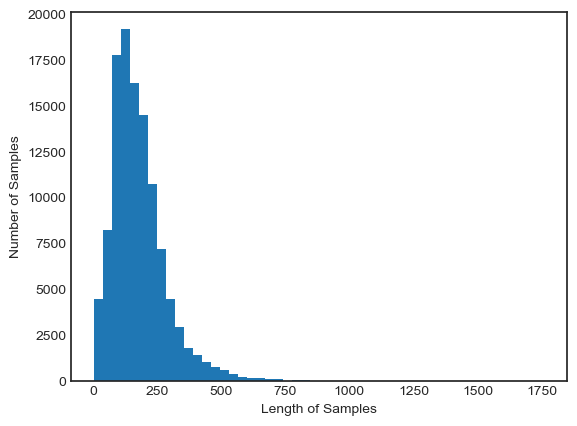

In [17]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [18]:
max_len = 800

In [19]:
# X_train과 X_test의 각 시퀀스들의 길이를 max_len으로 맞추는 작업을 수행하고 있습니다.

# 예를 들어, 만약 max_len이 100이라고 하면, 각 시퀀스의 길이가 100보다 작으면 부족한 부분을 0으로 채워서 길이를 100으로 만들어줍니다. 
# 만약 시퀀스의 길이가 100보다 크다면, 잘라서 길이를 100으로 만들어줍니다.

# 이렇게 패딩을 수행하면, 모델이 다양한 길이의 시퀀스를 처리할 수 있게 되며, 일정한 형태로 데이터를 입력으로 받을 수 있게 됩니다.

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [20]:
# (CNN) 기반의 텍스트 분류 모델을 설정하는 데 사용되는 하이퍼파라미터들을 정의

embedding_dim = max_len # 임베딩 벡터의 차원, 텍스트 데이터를 임베딩하여 고차원 벡터로 변환
dropout_ratio = 0.4 # 드롭아웃 비율, 드롭아웃은 모델의 과적합을 방지하고 일반화 성능을 향상시키기 위해 사용되는 정규화 기법
num_filters = 2 # 커널의 수,  CNN은 여러 개의 커널을 사용하여 다양한 특징을 추출
kernel_size = 3 # 커널의 크기, 텍스트 데이터에서 연속된 단어들을 몇 개씩 묶어서 특징을 추출
hidden_units = 128 # 은닉층의 뉴런 수

In [21]:
model = Sequential() # Sequential 모델 객체를 생성. 이 객체는 레이어를 순차적으로 쌓아 모델을 정의.
model.add(Embedding(vocab_size, embedding_dim)) # 이 레이어는 단어를 고차원 벡터로 변환하는 역할
model.add(Dropout(dropout_ratio)) # 모델의 일반화를 향상시키기 위해 뉴런을 임의로 비활성화하는 드롭아웃 기법
model.add(Conv1D(num_filters, kernel_size, padding = 'valid', activation = 'relu')) #  주어진 kernel_size와 num_filters로 텍스트 데이터의 지역적 특징을 추출합니다. 활성화 함수로 'relu'를 사용하며, 'valid' 패딩을 적용하여 출력 크기를 조절
model.add(GlobalMaxPooling1D()) # 각 필터에서 가장 높은 특징값을 선택하여 모아 전체 시퀀스의 특징 벡터를 만듭니다.
model.add(Dense(hidden_units, activation='relu'))  #  hidden_units 개의 뉴런으로 구성되며, 'relu' 활성화 함수를 사용
model.add(Dropout(dropout_ratio)) # 다시 한 번 드롭아웃 레이어를 적용
model.add(Dense(1, activation = 'sigmoid')) # 이진 분류 문제를 다루기 위해 'sigmoid' 활성화 함수를 사용

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 800)         102995200 
                                                                 
 dropout (Dropout)           (None, None, 800)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 2)           4802      
                                                                 
 global_max_pooling1d (Glob  (None, 2)                 0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               384       
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [22]:
# Keras의 EarlyStopping과 ModelCheckpoint 콜백을 설정하는 부분
# 이 두 가지 콜백은 모델 학습 과정을 조정하고 모니터링하는 데 사용


es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = ModelCheckpoint('TextCNN_best_model(learning_rate).h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

In [23]:
import tensorflow as tf
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate = 0.005), loss='binary_crossentropy', metrics = ['acc'])
history = model.fit(X_train, y_train, epochs=10, validation_split = 0.2, callbacks=[es, mc], batch_size = 128)

Epoch 1/10


C:\Users\이수호\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 102995200 elements. This may consume a large amount of memory.
  warnings.warn(


707/707 [==============================] - ETA: 0s - loss: 0.6429 - acc: 0.6487
Epoch 1: val_acc improved from -inf to 0.64893, saving model to TextCNN_best_model(learning_rate).h5


C:\Users\이수호\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


707/707 [==============================] - 2573s 4s/step - loss: 0.6429 - acc: 0.6487 - val_loss: 0.6472 - val_acc: 0.6489
Epoch 2/10
707/707 [==============================] - ETA: 0s - loss: 0.6156 - acc: 0.6515
Epoch 2: val_acc did not improve from 0.64893
707/707 [==============================] - 4223s 6s/step - loss: 0.6156 - acc: 0.6515 - val_loss: 0.6488 - val_acc: 0.6458
Epoch 3/10
707/707 [==============================] - ETA: 0s - loss: 0.5795 - acc: 0.6721
Epoch 3: val_acc did not improve from 0.64893
707/707 [==============================] - 4192s 6s/step - loss: 0.5795 - acc: 0.6721 - val_loss: 0.6537 - val_acc: 0.6260
Epoch 4/10
707/707 [==============================] - ETA: 0s - loss: 0.5457 - acc: 0.6995 
Epoch 4: val_acc did not improve from 0.64893
707/707 [==============================] - 13673s 19s/step - loss: 0.5457 - acc: 0.6995 - val_loss: 0.6791 - val_acc: 0.6170
Epoch 4: early stopping


In [24]:
loaded_model = load_model('TextCNN_best_model(learning_rate).h5')
loaded_model.evaluate(X_test, y_test)

596/596 [==============================] - 26s 43ms/step - loss: 0.7380 - acc: 0.4403


[0.7380066514015198, 0.4402981102466583]